# TIME SERIES ANALYSIS


**Goal:** Find outliers, trends and periodicity in the MTA turnstyle data
    
**Data:**
* **MTA subway fares**: It is a complete dataset of rides logged by card swipes for 600 Manhattan stations.
* *The data was organized  by Sina Kashuk at CUSP.*
* *It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass…) as follows*

**Outline**
* Task 1: 
    * Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
    * Identify it and figure out what it is due to.


* Task 2: 
    * Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


* Task 3: 
    * Build a classifier that assigns a card type to a time series based on time series features


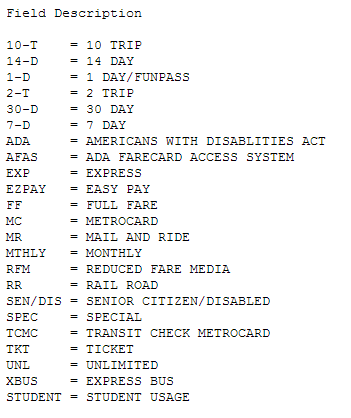

In [810]:
from __future__ import print_function, division
import matplotlib.pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

In [13]:
mta = np.load("MTA_Fare.npy")
mta.shape

(600, 23, 194)

In [14]:
mta.mean()

2157.8262034961899

In [15]:
#convert missing values of -1 to nan
mta = mta.astype('float')
mta[mta == -1] = np.nan

In [16]:
np.nanmean(mta)

2849.4162786534275

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# Load Data

In [20]:
# Load initial data and report shape
mta = np.load("MTA_Fare.npy")
mta = mta.astype('float')
mta[mta == -1] = np.nan

In [21]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


Create a "ride types" list based on the metadata I was given

In [329]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [56]:
# Date Range
daterange = pd.date_range(start='2010-05-21', 
                          freq='W-FRI', periods=194)

(0, 194)

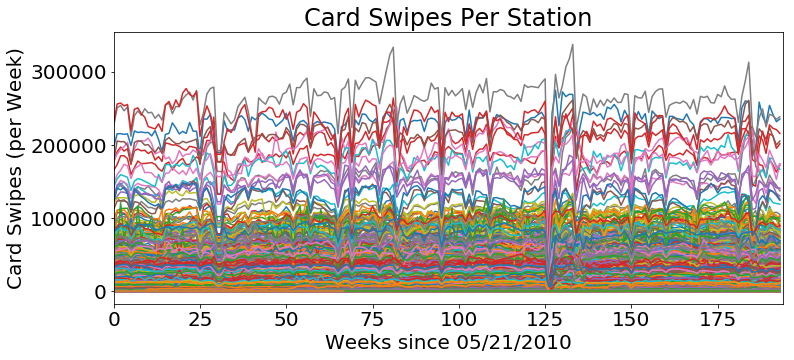

In [104]:
# Natural Space for all stations, all card types (independent)
pl.figure(figsize=(12,5))

for x in mta: 
    for y in x:
        plotme = pd.DataFrame(y,columns=['sum'])
        plotme.reset_index(inplace=True)
        pl.plot(plotme['index'],plotme['sum'])

pl.title('Card Swipes Per Station')
pl.ylabel('Card Swipes (per Week)')
pl.xlabel('Weeks since 05/21/2010')
pl.xlim(0,194)

**Figure 1:** Time series for all stations, and all card types in natural space. 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


(0, 194)

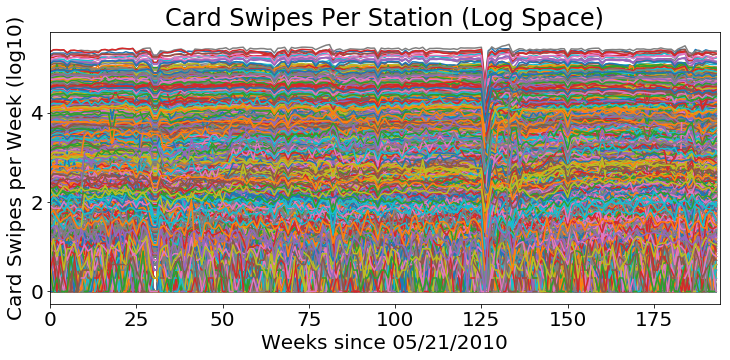

In [105]:
# Log Space all stations, all card types
pl.figure(figsize=(12,5))

for x in mta: 
    for y in x:
        plotme = pd.DataFrame(y,columns=['sum'])
        plotme.reset_index(inplace=True)
        pl.plot(plotme['index'],np.log10(plotme['sum']))

pl.title('Card Swipes Per Station (Log Space)')
pl.ylabel('Card Swipes per Week (log10)')
pl.xlabel('Weeks since 05/21/2010')
pl.xlim(0,194)

**Figure 2:** Time series for all ride types and all stations in semi-log space

# 1: Event detection 

**Event detection:** Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 

In [128]:
#summing for each week and station
summedAll = np.nansum(mta,axis=(0,1))
i = np.where(summedAll < (3 * summedAll.std()))
print(daterange[i[0][0]])

2012-10-19 00:00:00


In [130]:
Image(url='https://amp.businessinsider.com/images/5633a10e9dd7ccfc418bb004-2732-1366.jpg')

**Hurricane Sandy** happened during this week (actual date 10/22/2012) and closed downed the subway and mta for several days

 # 2: Finding trends

Instructions:
* Find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

* To do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

* Use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

* Notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. 

In [258]:
# Sum all on first axis (stations) to get an array of shape (23,194)
summedRideType = pd.DataFrame(np.nansum(mta,axis=(0)))
summedRideType.shape

(23, 194)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


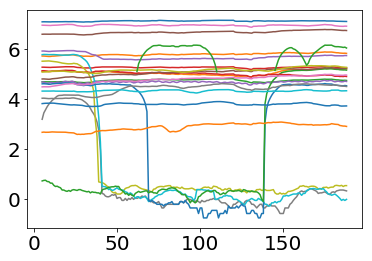

In [395]:
# Using rolling window to smooth
smooth = summedRideType.rolling(11, axis=1, center=True).mean()

# Plot to visually inspect
for i in range(len(smooth)):
    pl.plot(range(len(smooth.iloc[i])),np.log10(smooth.iloc[i]))

**Figure 3**: Visually we can see that even by smoothing, we have some missing data for some of the card types

In [396]:
change = smooth[5]/smooth[188] #find ratio of change
maxchange = np.argmax(change) #what had the greatest amount of change?
minchange = np.argmin(change)
stdev = np.nanstd(smooth,axis=1) #what does distribution look like
Evaluate = pd.DataFrame(change).merge(pd.DataFrame(stdev),
                                      left_index=True,
                                      right_index=True)

#Visually inspect change
Evaluate.rename(columns={'0_x':'ChangeRatio','0_y':'StdDev'},
               inplace=True)
Evaluate.sort_values(by=['ChangeRatio','StdDev'],ascending=False)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


,ChangeRatio,StdDev
9,604860.545455,204218.764366
8,93138.820513,100174.991424
7,5026.625000,3761.274187
13,1.692343,17078.384119
14,1.518496,152073.588552
20,1.239742,665.526432
10,1.192691,18737.974343
6,1.096204,443885.638513
3,1.059226,8546.953809
19,0.971298,1500.473983


### Decreasing Change

In [397]:
print("Card Type 13: ({})\nstdev: {}, ratio of change over time: {}".format(
                                                ridetype[13],
                                                summedRideType.iloc[13].std(),
                                                change[13]))

print("\nCard Type 14: ({})\nstdev: {}, ratio of change over time: {}".format(
                                                ridetype[14],
                                                summedRideType.iloc[14].std(),
                                                change[14]))

Card Type 13: (month)
stdev: 23803.335905342286, ratio of change over time: 1.692342926426755

Card Type 14: (rfm)
stdev: 171720.74684189362, ratio of change over time: 1.5184957541208843


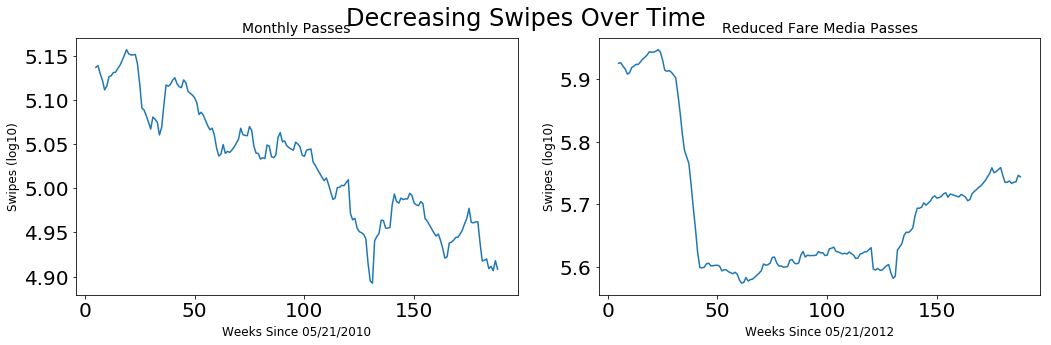

In [699]:
# Decreasing Ridership by Card Type
plt.figure(figsize=(15,5))
plt.suptitle('Decreasing Swipes Over Time')
ax1=plt.subplot(121)
ax1.set_title('Monthly Passes', fontsize=14)
ax1.plot(range(len(smooth.iloc[13])), np.log10(smooth.iloc[13]))
ax1.set_xlabel('Weeks Since 05/21/2010', fontsize=12)
ax1.set_ylabel('Swipes (log10)', fontsize=12)

ax2=plt.subplot(122)
ax2.set_title('Reduced Fare Media Passes', fontsize=14)
ax2.plot(range(len(smooth.iloc[14])), np.log10(smooth.iloc[14]))
ax2.set_xlabel('Weeks Since 05/21/2012', fontsize=12)
ax2.set_ylabel('Swipes (log10)', fontsize=12)

plt.tight_layout()

**Figure 3:** After evaluating my 'change ratios', **I determined that Monthly MTA passes (left) had the largest decreasing change with a clear trend** (as measured by a change ratio of $1.69$ and standard deviation of $23803$). 'Reduced Fare Media' passes (right)  had a similar change ratio of $1.52$, but a much higher standard deviation of $171720$, and the resultant graph shows the corresponding variance.

### Increasing Change

In [405]:
print("Card Type 16: ({})\nstdev: {}, ratio of change over time: {}".format(
                                                ridetype[16],
                                                summedRideType.iloc[16].std(),
                                                change[16]))

print("\nCard Type 17: ({})\nstdev: {}, ratio of change over time: {}".format(
                                                ridetype[17],
                                                summedRideType.iloc[17].std(),
                                                change[17]))

Card Type 16: (sen)
stdev: 20770.899349172058, ratio of change over time: 0.33880951089234895

Card Type 17: (spec)
stdev: 12103.843260331154, ratio of change over time: 0.04906113407901523


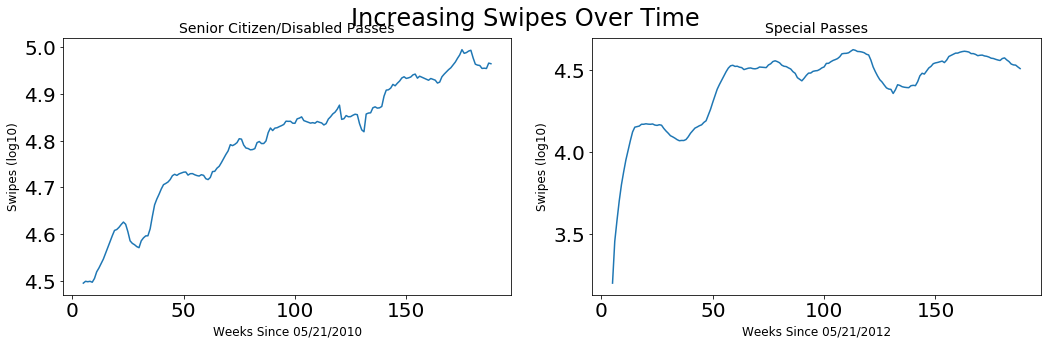

In [407]:
# Increasing Ridership by Card Type
plt.figure(figsize=(15,5))
plt.suptitle('Increasing Swipes Over Time')
ax1=plt.subplot(121)
ax1.set_title('Senior Citizen/Disabled Passes', fontsize=14)
ax1.plot(range(len(smooth.iloc[16])), np.log10(smooth.iloc[16]))
ax1.set_xlabel('Weeks Since 05/21/2010', fontsize=12)
ax1.set_ylabel('Swipes (log10)', fontsize=12)

ax2=plt.subplot(122)
ax2.set_title('Special Passes', fontsize=14)
ax2.plot(range(len(smooth.iloc[17])), np.log10(smooth.iloc[17]))
ax2.set_xlabel('Weeks Since 05/21/2012', fontsize=12)
ax2.set_ylabel('Swipes (log10)', fontsize=12)

plt.tight_layout()

**Figure 4:** After evaluating my 'change ratios', **I determined that Senior Citizen/Disabled MTA passes (left) had the largest increasing change with a clear trend** (as measured by a change ratio of $0.34$ and standard deviation of $20770$). 'Special' passes (right) actually had a more dramatic change ratio of $0.05$ and an even smaller standard deviation of $12103$, but the sharp initial increase indicates missing data.  


# 3. Build  models that classify the *ride type* based on the time series characteristics using random forests. 

* Clean the data from missing values (drop time series with NaNs)

* Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

* Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

* Split the training and test data (66%/33%)

* Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

* Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

* Plot a confusion matrix for each model (discuss)

* Compare the models using sklearn.metrics classification_report

* Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

### Feature Engineering: Normalize Mean & Std Dev for Each Station

In [929]:
# Drop all card types with nan values
mask = np.any(np.isnan(mta), axis=2) # method 1 (total shape: 9174)

mask2 = mta.reshape(600*23, 194).std(1) > 0 # method 2 (excludes more, total shape: 7660 )
mask2 = mask2.reshape(600, 23)

mta[mask2].shape , mta[~mask].shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


((7660, 194), (9174, 194))

In [930]:
# Create Labels
label = np.tile(np.array(range(23)),600)
flattenedmask = mask2.flatten()
label = label[flattenedmask]
label.shape

(7660,)

In [931]:
# Card type labels
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18,  0,  1,  2,  3,  4,  5,  6,  7])

In [932]:
#calculate mean & std dev for card types without nan values
means = np.ones((600,23))
stds = np.ones((600,23))

for x in range(len(mta)): #simple for loop with 
    for i in range(23):
        if (mask2[x][i]):
            means[x][i] = np.mean(mta[x][i])
            stds[x][i] = np.std(mta[x][i])

means[means == 1] = np.nan #get rid of 1 values
stds[stds == 1] = np.nan #get rid of 1 values
means[2], stds[2]    

(array([  3.54891753e+03,   1.44587629e+02,   1.79381443e+01,
          3.02577320e+01,   2.89690722e+00,   1.72666495e+03,
          1.25873711e+03,   3.86597938e-01,   4.62886598e+00,
          3.00618557e+01,   9.53608247e-01,   1.73865979e+01,
          1.57989691e+01,   8.24226804e+00,   9.27525773e+01,
          1.23505155e+01,   3.29896907e+00,              nan,
          1.15309278e+01,              nan,              nan,
                     nan,              nan]),
 array([ 391.40042433,   43.60075488,    8.13711673,    9.80981872,
           4.23530701,  286.20893188,  182.35136007,    1.22685827,
          11.1163663 ,   67.14683317,    1.84807294,    9.5782198 ,
          27.87704593,    5.89671121,   43.53693323,    3.55528135,
           2.7793975 ,           nan,    8.21185792,           nan,
                  nan,           nan,           nan]))

In [933]:
# Means per station
stationsmeans = np.nanmean(means, axis=1)
stationsmeans.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(600,)

In [934]:
# Std Devs per station
stationsstd = np.nanstd(stds, axis=1)
stationsstd.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(600,)

In [935]:
# Create Station ID's for all values
stationid = np.repeat(range(600),23)
stationid = stationid[mask2.flatten()]
stationid.shape

(7660,)

In [936]:
# Apply mask to MTA 
tots = mta[mask2]
tots.shape

(7660, 194)

In [937]:
# Normalizeing mean and std dev for each station
normed_time_series_mean = np.ones_like(stationid).astype(float)
normed_time_series_std = np.ones_like(stationid).astype(float)

for i in range(600):
    indexvals = np.where(stationid == i) # Get TS indices for all other card types in station
    for x in indexvals[0]: 
        val = tots[x] # Get TS for row
        normed_time_series_mean[x] = np.mean(val) / stationsmeans[i] # normed by mean
        normed_time_series_std[x] = np.std(val) / stationsstd[i] # normed by std dev

normed_time_series_mean[:10], normed_time_series_std[:10]

(array([  9.22143828e+00,   3.75693683e-01,   4.66101254e-02,
          7.86211022e-02,   7.52726737e-03,   4.48653262e+00,
          3.27067803e+00,   1.00452856e-03,   1.20275553e-02,
          7.81121411e-02]),
 array([ 3.6262539 ,  0.40395308,  0.07538891,  0.09088619,  0.03923935,
         2.65167381,  1.68945226,  0.01136662,  0.10299112,  0.62210322]))

### Standardize Each Individual Time Series for Plotting

In [938]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape, tsmean[:10]

((7660,), array([  3.54891753e+03,   1.44587629e+02,   1.79381443e+01,
          3.02577320e+01,   2.89690722e+00,   1.72666495e+03,
          1.25873711e+03,   3.86597938e-01,   4.62886598e+00,
          3.00618557e+01]))

In [939]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev.shape, tsstdev[:10]

((7660,), array([ 391.40042433,   43.60075488,    8.13711673,    9.80981872,
           4.23530701,  286.20893188,  182.35136007,    1.22685827,
          11.1163663 ,   67.14683317]))

In [940]:
# Standardize each time series 
standardizedts = np.ones_like(tots).astype(float)

for i in range(len(tots)):
    for x in range(194):
        val = tots[i][x]
        standardizedts[i][x] = (val - tsmean[i])/tsstdev[i] # standard scaler
        
standardizedts[:10]

array([[-0.65640584, -0.30638067,  0.20460498, ...,  0.50353158,
        -0.36514402, -0.84802546],
       [-0.79328051, -1.20611739, -0.97676357, ...,  1.54612853,
         1.47732238,  1.52319315],
       [-1.34422851, -1.46712217, -0.6068666 , ...,  0.99075089,
         0.25338898,  0.49917628],
       ..., 
       [-0.31511214,  0.49997793, -0.31511214, ..., -0.31511214,
        -0.31511214, -0.31511214],
       [ 2.82206732,  0.84300335,  3.18189713, ..., -0.41640099,
        -0.41640099, -0.41640099],
       [ 2.14363266,  2.47127283,  2.47127283, ..., -0.44770325,
        -0.44770325, -0.44770325]])

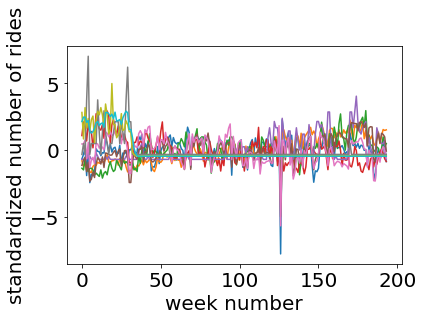

In [941]:
for i in range(10):
    plt.plot(standardizedts[i])
plt.xlabel("week number")
plt.ylabel("standardized number of rides")

### Feature Engineering: Get Intercept & slope of each Time Series

In [942]:
# Fit an ordinary least squares model for each time series (not standardized?)
allfits = []

for x in range(len(standardizedts)):
    fit = smf.ols('y ~ x + 1', data={
        'y':tots[x],'x':np.array(range(len(tots[x])))
    }).fit()
    allfits.append(fit)
    
[(a.params[0]) for a in allfits[:10]]

[3545.2318794607445,
 81.160348929421076,
 9.2390166534496423,
 40.726566217287861,
 -1.4374306106264856,
 1477.2713719270421,
 1363.03425852498,
 1.3029341792228388,
 16.241554321966689,
 104.16367961934969]

### Create Train/Test Split on 4 Engineered Features

In [943]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], 
              [a.params[1] for a in allfits],
              normed_time_series_mean, 
              normed_time_series_std]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [944]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

In [945]:
# Are there any infinite values?
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [946]:
# X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

### Create Random Forest Classifier using 4 Engineered Features in Train/Test Data

In [947]:
clf = rfc().fit(X_train,y_train)
clf.score(X_train,y_train)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.98772408417770852

### Analyze Results

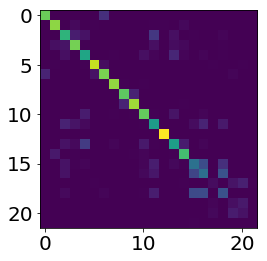

In [948]:
y_pred = clf.predict(X_test)
imshow(confusion_matrix(y_test, y_pred))

**Interpretation of CLF score and confusion matrix**
Based off of my score of $0.986$ and a visual inspection of my confusion matrix, my classifier did a good job of predicting the card type labels. However, the score was so high that I'm worried my model is overfitting.

In [949]:
print(classification_report(y_test, y_pred, target_names=ridetype[:-1])) # dropped some stud values since all seemed to get dropped

              precision    recall  f1-score   support

         10t       0.88      0.85      0.87       135
         14d       0.88      0.92      0.90       133
          1d       0.64      0.65      0.65       148
          2t       0.79      0.80      0.79       147
         30d       0.62      0.70      0.66       124
          7d       0.94      0.94      0.94       144
         ada       0.81      0.83      0.82       142
        afas       0.97      0.98      0.98       126
         exp       0.87      0.89      0.88       125
          ez       0.89      0.89      0.89       143
          ff       0.81      0.82      0.82       137
          mc       0.54      0.59      0.56       138
          mr       0.99      0.99      0.99       149
       month       0.68      0.57      0.62       146
         rfm       0.83      0.87      0.85       119
          rr       0.44      0.40      0.42       138
         sen       0.38      0.38      0.38       142
        spec       0.45    

**Classification report interpretation:**
Based off of this table, I had a both weighted precision & recall averages of $0.72$, with the highest values for mr, 7d, and exp card types. In general, wherever I had high precision values, I had similarly high recall values and vice versa. As a reminder to myself, here are the definitions for each:
* Precision: how many selected items are relevant
* Recall: How many relevant items are selected

In [950]:
clf.feature_importances_

array([ 0.18513996,  0.25243954,  0.32590627,  0.23651423])

According to this, the **normalized time series mean is the most important feature**, and our **slope (measure of increasing/decreasing) is the second most important** out of our 4 engineered features. 

## Build a model that uses as input features each time stamp (194 features) :


In [951]:
# use the same split ratio
X_train2, X_test2, y_train2, y_test2 = train_test_split(tots,      
     label, test_size=0.33, random_state=42, shuffle=True)

np.array(X_train2).shape, np.array(X_test2).shape, np.array(y_train2).shape, np.array(y_test2).shape

((5132, 194), (2528, 194), (5132,), (2528,))

In [952]:
clf2 = rfc().fit(X_train2,y_train2)
clf2.score(X_train2,y_train2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.99006235385814501

### Analyze RFC using all 194 features

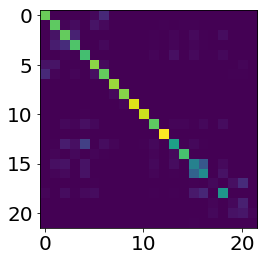

In [953]:
y_pred2 = clf2.predict(X_test2)
imshow(confusion_matrix(y_test2, y_pred2))

In [954]:
print(classification_report(y_test2, y_pred2, target_names=ridetype[:-1]))

              precision    recall  f1-score   support

         10t       0.82      0.85      0.83       135
         14d       0.73      0.83      0.78       133
          1d       0.68      0.76      0.72       148
          2t       0.75      0.73      0.74       147
         30d       0.66      0.84      0.74       124
          7d       0.81      0.85      0.83       144
         ada       0.77      0.80      0.78       142
        afas       0.95      1.00      0.98       126
         exp       0.98      0.97      0.98       125
          ez       1.00      0.99      0.99       143
          ff       0.99      0.99      0.99       137
          mc       0.88      0.80      0.84       138
          mr       0.99      0.99      0.99       149
       month       0.79      0.58      0.66       146
         rfm       0.96      0.88      0.92       119
          rr       0.47      0.47      0.47       138
         sen       0.53      0.51      0.52       142
        spec       0.33    

In [955]:
importance = clf2.feature_importances_
one = np.sort(importance)[-1]
two = np.sort(importance)[-2]
daterange[np.where(importance==one)], daterange[np.where(importance==two)]

(DatetimeIndex(['2011-01-14'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2010-12-10'], dtype='datetime64[ns]', freq=None))

## Interpretation:
Every measure of my second RFC (using time series as input) was higher than my RFC using engineered features. This included a score of $0.99$, weighted precision & recall averages of $0.78$, and a visually smooth confusion matrix. 

Looking at the feature importance, **our most important weeks/features were that of 01/07/2011 & 05/21/2010$. I searched for important events in the city during the first week, but was unable to find anything. The second week is obvious, since it is the first week of our data. This means the ridership during first week was a good predictor of card type (relative to the 192 other features). 

However, the benefit of the first RFC is that it used much less features in the classifier. This would help with computation speed as our N gets larger or if we're studying a larger time frame (i.e. more features). 